In [1]:
!python -V

Python 3.11.3


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/ubuntu/experiment-tracking/mlruns/1', creation_time=1684852122439, experiment_id='1', last_update_time=1684852122439, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
def read_dataframe(filename, drop_outliers = True):
    
    df = pd.read_parquet(filename)

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)

    if drop_outliers:
        df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [8]:
#df_train_with_outliers = read_dataframe('./data/yellow_tripdata_2022-01.parquet', drop_outliers = False)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO']#['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.415110936982529

/tmp/ipykernel_3517/390297872.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


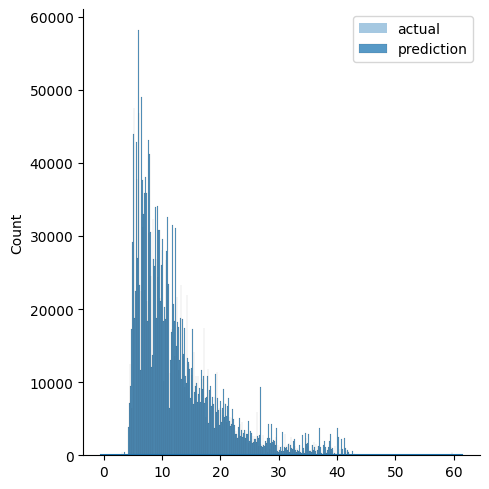

In [18]:
sns.displot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "GSDRF")
    
    mlflow.log_param("train-data-path", "./data/yellow_tripdata_2022-01.parquet")
    mlflow.log_param("val-data-path", "./data/yellow_tripdata_2022-02.parquet")
    
    alpha = 0.01
    
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle/")

MlflowException: Invalid artifact path: 'models_pickle/'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'models_pickle'

In [57]:
lr = Ridge(alpha=.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.426826495645482

In [13]:
import xgboost as xgb

In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [15]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=20,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=Trials()
)

[14:19:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.69205                                                                        
[1]	validation-rmse:15.02783                                                                        
[2]	validation-rmse:14.42506                                                                        
[3]	validation-rmse:13.87873                                                                        
[4]	validation-rmse:13.38370                                                                        
[5]	validation-rmse:12.93545                                                                        
[6]	validation-rmse:12.53114                                                                        
[7]	validation-rmse:12.16515                                                                        
[8]	validation-rmse:11.83682                                             

[16]	validation-rmse:9.01024                                                                        
[17]	validation-rmse:8.93753                                                                        
[18]	validation-rmse:8.87508                                                                        
[19]	validation-rmse:8.81714                                                                        
[14:25:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.86100                                                                        
[1]	validation-rmse:13.59137                                                                        
[2]	validation-rmse:12.56567                                                                        
[3]	validation-rmse:11.73627                                                                        
[4]	validation-rmse:11.06221                                             

[12]	validation-rmse:7.67246                                                                        
[13]	validation-rmse:7.61527                                                                        
[14]	validation-rmse:7.55923                                                                        
[15]	validation-rmse:7.50672                                                                        
[16]	validation-rmse:7.45822                                                                        
[17]	validation-rmse:7.41112                                                                        
[18]	validation-rmse:7.36722                                                                        
[19]	validation-rmse:7.32636                                                                        
[14:31:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.25933                                             

[8]	validation-rmse:8.61831                                                                         
[9]	validation-rmse:8.53651                                                                         
[10]	validation-rmse:8.47022                                                                        
[11]	validation-rmse:8.40545                                                                        
[12]	validation-rmse:8.35276                                                                        
[13]	validation-rmse:8.30133                                                                        
[14]	validation-rmse:8.25423                                                                        
[15]	validation-rmse:8.20759                                                                        
[16]	validation-rmse:8.16652                                                                        
[17]	validation-rmse:8.12464                                                               

In [26]:
params = {
'learning_rate': 0.9809594318164628,
'max_depth': 28, 
'min_child_weight': 8.521630596202131,
'objective': 'reg:linear',
'reg_alpha': 0.015656836827151036,
'reg_lambda': 0.18258864885464157,
'seed': 42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )


2023/05/24 15:38:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '014b4202d88445b885ad870db0a2d4b0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:38:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.25257
[1]	validation-rmse:8.95741
[2]	validation-rmse:8.75771
[3]	validation-rmse:8.60104
[4]	validation-rmse:8.46320
[5]	validation-rmse:8.33225
[6]	validation-rmse:8.22673
[7]	validation-rmse:8.12319
[8]	validation-rmse:8.02985
[9]	validation-rmse:7.94601
[10]	validation-rmse:7.86400
[11]	validation-rmse:7.78715
[12]	validation-rmse:7.71652
[13]	validation-rmse:7.64857
[14]	validation-rmse:7.58253
[15]	validation-rmse:7.52689
[16]	validation-rmse:7.47296
[17]	validation-rmse:7.41926
[18]	validation-rmse:7.36923
[19]	validation-rmse:7.32109
[20]	validation-rmse:7.27669
[21]	validation-rmse:7.23430
[22]	validation-rmse:7.19253
[23]	validation-rmse:7.15403
[24]	validation-rmse:7.11518
[25]	validation-rmse:7.08339
[26]	validation-rmse:7.05127
[27]	validation-rmse:7.01893
[28]	validation-rmse:6.98973
[29]	validation-rmse:6.96081
[30]	validation-rmse:

2023/05/24 15:39:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [32]:
mlflow.xgboost.autolog(disable=True)

In [33]:
with mlflow.start_run():
    
    best_params = {
        'learning_rate': 0.9809594318164628,
        'max_depth': 28, 
        'min_child_weight': 8.521630596202131,
        'objective': 'reg:linear',
        'reg_alpha': 0.015656836827151036,
        'reg_lambda': 0.18258864885464157,
        'seed': 42,
    }

    mlflow.log_params(best_params)
    
    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=50,
                evals=[(valid, 'validation')],
                early_stopping_rounds=10
            )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
        
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")     
        
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[15:59:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.25257
[1]	validation-rmse:8.95741
[2]	validation-rmse:8.75771
[3]	validation-rmse:8.60104
[4]	validation-rmse:8.46320
[5]	validation-rmse:8.33225
[6]	validation-rmse:8.22673
[7]	validation-rmse:8.12319
[8]	validation-rmse:8.02985
[9]	validation-rmse:7.94601
[10]	validation-rmse:7.86400
[11]	validation-rmse:7.78715
[12]	validation-rmse:7.71652
[13]	validation-rmse:7.64857
[14]	validation-rmse:7.58253
[15]	validation-rmse:7.52689
[16]	validation-rmse:7.47296
[17]	validation-rmse:7.41926
[18]	validation-rmse:7.36923
[19]	validation-rmse:7.32109
[20]	validation-rmse:7.27669
[21]	validation-rmse:7.23430
[22]	validation-rmse:7.19253
[23]	validation-rmse:7.15403
[24]	validation-rmse:7.11518
[25]	validation-rmse:7.08339
[26]	validation-rmse:7.05127
[27]	validation-rmse:7.01893
[28]	validation-rmse:6.98973
[29]	validation-rmse:6.96081
[30]	validation-rmse:

In [34]:
logged_model = 'runs:/3f2b9c1802324254b560d2f317772f57/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


2023/05/24 16:02:01 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[16:02:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 3f2b9c1802324254b560d2f317772f57

In [36]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[16:02:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
xgboost_model

In [38]:
y_pred = xgboost_model.predict(valid)

In [39]:
y_pred[:10]

array([14.707319, 14.707319, 14.707319, 14.707319, 32.633465, 14.707319,
       14.707319,  6.20014 , 14.707319, 14.707319], dtype=float32)